<a href="https://colab.research.google.com/github/Homiez09/nlp-review-colab/blob/main/Ass_5_WordEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# download data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo' -O w_review_train.csv

# download font for matplot
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DsfYE5uI1ZA_IXDNkezQTv-NQehxgZQy' -O THSarabun.ttf

# install library
!pip install gensim
!pip install pythainlp

--2023-08-17 22:05:01--  https://docs.google.com/uc?export=download&id=1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo
Resolving docs.google.com (docs.google.com)... 74.125.135.113, 74.125.135.102, 74.125.135.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/utmndnrveldd4sq5cb4e3rsf7pjgng44/1692309900000/07034668329300256193/*/1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo?e=download&uuid=83cdcb71-846a-4881-bad9-09d0ae6b3b4e [following]
--2023-08-17 22:05:05--  https://doc-0o-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/utmndnrveldd4sq5cb4e3rsf7pjgng44/1692309900000/07034668329300256193/*/1nckRRVYRiWG8VWoUY4wwtuQm6DjIbpmo?e=download&uuid=83cdcb71-846a-4881-bad9-09d0ae6b3b4e
Resolving doc-0o-90-docs.googleusercontent.com (doc-0o-90-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:4

# loading data

In [4]:
from gensim.models import Word2Vec

from pythainlp import word_tokenize
from pythainlp.util import dict_trie
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import pandas as pd
import numpy as np
import re

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

In [ ]:
train = pd.read_csv("w_review_train.csv", encoding='utf8', names=["sentence"])
train.head(10)

,sentence
0,ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้...
1,อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา...
2,ปอเปี๊ยะสด ทุกวันนี้รู้สึกว่าหากินยาก (ร้านที่...
3,รัานคัพเค้กในเมืองไทยมีไม่มาก หลายๆคนอาจจะสงสั...
4,อร่อย!!! เดินผ่านDigital gatewayทุกวัน ไม่ยักร...
5,ร้านข้าวต้มกระดูกหมู ปากซอยพัฒนาการ 57 เป็นอีก...
6,วันนี้ได้มีโอกาสไปนั่งซดกาแฟที่ร้านวาวี แถวๆอา...
7,สารภาพว่าไม่เคยคิดจะไปต่อคิวซื้อมากินเองครับ บ...
8,เมื่อวันก่อนไปเดินเล่น แบบชิวๆๆ ที่สยามสแควร์แ...
9,วันก่อนไปเดินสยาม หลังจากห่างหายไป ประมาณ 6 เด...


# Creating model and training model using gensim

In [5]:
# add word to dict
words = ['บะหมี่แห้ง', 'ข้าวหมูกรอบ', 'ก๋วยเตี๋ยวหมูต้มยำ', 'ปลากระพงทอดน้ำปลา', 'ซูชิ', 'กาแฟ', 'ชานมไข่มุก', 'เค้กช็อกโกแลต', 'เครปเค๊ก', 'ไอศครีม']
custom_words_list = set(thai_words())
custom_words_list.update(words)
trie = dict_trie(dict_source=custom_words_list)

In [7]:
STOP_WORD = list(thai_stopwords()) + [" ", "\n"]

FORMAT = r"[\u0E00-\u0E7Fa-zA-Z'0-9]+"

In [8]:
def tokenize(sentence):
  return word_tokenize(sentence, engine="newmm", custom_dict=trie)

def cleaning_stop_word(tk_list):
  return [word for word in tk_list if word not in STOP_WORD]

def cleaning_symbols_emoji(tk_list):
  return [re.findall(FORMAT, text)[0] for text in tk_list if re.findall(FORMAT, text)]

**Word2Vec Function:**
* **tokenized_list** เป็นข้อมูลที่ใช้ train โมเดล โดยจะอยู่ในลักษณะของ list ของ list ของ tokens (คำในแต่ละรีวิว)

* **vector_size** เป็นจำนวนมิติของ embedding layer (ขนาดของ embedded  vector) ที่ต้องการ

* **window** คือจำนวนคำใกล้เคียงที่เกิดขึ้นร่วมกันกับคำที่กำลังฝึกฝนอยู่

* **min_count** คือ จำนวนขั้นต่ำของคำที่ปรากฎในข้อมูลการ train ทั้งหมด (คำที่ปรากฎน้อยจะไม่สนใจ)

* **worker** คือจำนวนของ computer threads ที่จะใช้ในการ train

* **sg** คือ ถ้า =0 คือ train ด้วย CBOW, =1 คือ train ด้วย Skip-gram (ปกติ Skip-gram จะใช้เวลา train นานกว่า CBOW)

* **epochs** คือ จำนวนรอบที่โมเดลจะ train ข้อมูล

In [10]:
# model 1: doesn't clean anything

tokenized_list = (train.sentence.apply(tokenize)).tolist()
model_1 = Word2Vec(tokenized_list, vector_size=100, window=5, min_count=5, workers=4)

In [12]:
# model 2: only cleaning stopword

def tk_with_no_stop_word(sentence):
  return cleaning_stop_word(tokenize(sentence))

tokenized_list = (train.sentence.apply(tk_with_no_stop_word)).tolist()
model_2 = Word2Vec(tokenized_list, vector_size=100, window=5,  min_count=5, workers=4)

In [13]:
# model 3: only cleaning symbols and emoji

def tk_with_no_symbols(sentence):
  return cleaning_symbols_emoji(tokenize(sentence))

tokenized_list = (train.sentence.apply(tk_with_no_symbols)).tolist()
model_3 = Word2Vec(tokenized_list, vector_size=100, window=5, min_count=5, workers=4)

In [14]:
# model 4: cleaning stopword, symbols and emoji and more train wongnai to pretrained model

# load pretrained model
model_4 = Word2Vec.load('http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin')

def big_cleaning(sentence):
  return cleaning_symbols_emoji(cleaning_stop_word(tokenize(sentence)))

tokenized_list = (train.sentence.apply(big_cleaning)).tolist()
model_4.build_vocab(corpus_iterable=tokenized_list, update=True)
model_4.train(corpus_iterable=tokenized_list, total_examples=model_4.corpus_count, epochs=10)


(25123169, 29517750)

In [15]:
# word similarity
print(model_1.wv.similarity('อร่อย', 'สุดยอด'))
print(model_2.wv.similarity('อร่อย', 'สุดยอด'))
print(model_3.wv.similarity('อร่อย', 'สุดยอด'))
print(model_4.wv.similarity('อร่อย', 'สุดยอด'))

0.50003433
0.5030673
0.5045188
0.5286137


In [16]:
print("doesn't clean anything:" , model_1.wv.most_similar("ชานมไข่มุก", topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar("ชานมไข่มุก", topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar("ชานมไข่มุก", topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar("ชานมไข่มุก", topn=5))

doesn't clean anything: [('กาแฟเย็น', 0.5949556231498718), ('ชาเย็น', 0.591265082359314), ('Mocktail', 0.5889405608177185), ('Espresso', 0.5703130960464478), ('Dakasi', 0.5605469942092896)]
only cleaning stopword: [('ยี่ห้อ', 0.7040711045265198), ('Dakasi', 0.6677097082138062), ('Mikucha', 0.6579504609107971), ('แบรนด์', 0.6433361768722534), ('True', 0.5964219570159912)]
only cleaing symbols and emoji: [('กาแฟเย็น', 0.6292036771774292), ('ชาเย็น', 0.5919564366340637), ('Dakasi', 0.5816904306411743), ('kakigori', 0.57972252368927), ('Mocha', 0.5776767730712891)]
cleaning stopword, symbols and emoji: [('Dakasi', 0.7171611785888672), ('ไข่มุก', 0.6288665533065796), ('ชาเย็น', 0.5830629467964172), ('Mikucha', 0.5829894542694092), ('เกรย์', 0.5627561807632446)]


In [17]:
print("doesn't clean anything:" , model_1.wv.most_similar("บะหมี่แห้ง", topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar("บะหมี่แห้ง", topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar("บะหมี่แห้ง", topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar("บะหมี่แห้ง", topn=5))

doesn't clean anything: [('บะหมี่', 0.7883269190788269), ('เย็นตาโฟ', 0.7416858673095703), ('เส้นหมี่', 0.7333297729492188), ('เส้นใหญ่', 0.7281951904296875), ('กระเพาะปลา', 0.7264816164970398)]
only cleaning stopword: [('บะหมี่', 0.8172010183334351), ('เกาเหลา', 0.7442358136177063), ('เย็นตาโฟ', 0.7409070730209351), ('ข้าวหมูกรอบ', 0.7398274540901184), ('เส้นหมี่', 0.738619863986969)]
only cleaing symbols and emoji: [('บะหมี่', 0.7649381756782532), ('เส้นหมี่', 0.7558929324150085), ('เส้นใหญ่', 0.7261244654655457), ('เกาเหลา', 0.7211264967918396), ('เย็นตาโฟ', 0.707927942276001)]
cleaning stopword, symbols and emoji: [('เส้นใหญ่', 0.7207707166671753), ('บะหมี่', 0.7077180743217468), ('ข้าวหมูกรอบ', 0.7041001319885254), ('เกาเหลา', 0.6576610207557678), ('เย็นตาโฟ', 0.652946412563324)]


In [18]:
print("doesn't clean anything:" , model_1.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar('ปลากระพงทอดน้ำปลา', topn=5))

doesn't clean anything: [('ทอดมันปลากราย', 0.8155755996704102), ('กุ้งแช่น้ำปลา', 0.7489373683929443), ('ผัดฉ่า', 0.6956031322479248), ('ต้มยำกุ้ง', 0.6551871299743652), ('ทอดมัน', 0.6483426690101624)]
only cleaning stopword: [('ทอดมันปลากราย', 0.7843119502067566), ('ปลาช่อน', 0.7412971258163452), ('กะพง', 0.7000645399093628), ('ทอดมัน', 0.6973022818565369), ('ปลาทู', 0.6936017870903015)]
only cleaing symbols and emoji: [('ทอดมันปลากราย', 0.8052738308906555), ('ปลาทู', 0.7261481881141663), ('แกงส้ม', 0.7104945182800293), ('กุ้งแช่น้ำปลา', 0.7099893689155579), ('ปลาช่อน', 0.6893789172172546)]
cleaning stopword, symbols and emoji: [('ทอดมันปลากราย', 0.7159808874130249), ('ฉู่ฉี่', 0.7098084092140198), ('แดดเดียว', 0.6888549327850342), ('ต้มโคล้ง', 0.6832149028778076), ('กะพง', 0.6830623149871826)]


In [19]:
print("doesn't clean anything:" , model_1.wv.most_similar('ซูชิ', topn=5))
print("only cleaning stopword:" , model_2.wv.most_similar('ซูชิ', topn=5))
print("only cleaing symbols and emoji:" , model_3.wv.most_similar('ซูชิ', topn=5))
print("cleaning stopword, symbols and emoji:" , model_4.wv.most_similar('ซูชิ', topn=5))

doesn't clean anything: [('ข้าวปั้น', 0.8342798948287964), ('ปลาดิบ', 0.7700872421264648), ('ปลาไหล', 0.7290379405021667), ('แซลมอน', 0.7027737498283386), ('ซา', 0.6083834171295166)]
only cleaning stopword: [('ข้าวปั้น', 0.860323965549469), ('ปลาดิบ', 0.8481649160385132), ('ปลาไหล', 0.7847398519515991), ('แซลมอน', 0.6815698742866516), ('ซา', 0.6381483674049377)]
only cleaing symbols and emoji: [('ปลาดิบ', 0.8312525749206543), ('ข้าวปั้น', 0.8010010123252869), ('ปลาไหล', 0.7154977321624756), ('แซลมอน', 0.6690947413444519), ('ซา', 0.5970801115036011)]
cleaning stopword, symbols and emoji: [('ปลาดิบ', 0.7993392944335938), ('ข้าวปั้น', 0.7912828326225281), ('ปลาไหล', 0.7290697693824768), ('แซลมอน', 0.6923843622207642), ('Sushi', 0.6534650325775146)]


# **Visualization**


In [20]:
plt.style.use("seaborn-notebook")

# setup font for matplotlib
thai_sarabun = FontProperties(fname="THSarabun.ttf", size=18)

<ipython-input-20-2386682631fc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-notebook")


In [21]:
# using PCA

def display_plot(words):
  models = [model_1, model_2, model_3, model_4]
  fig, axes = plt.subplots(2, 2, figsize=(14, 14))

  j, k = 0, 0

  for modelx in models:
      if k == 2:
        k = 0
        j = 1

      word_vectors = np.array( [ modelx.wv[w] for w in words ])

      twodim = PCA().fit_transform(word_vectors)[:,:2]

      axes[j][k].scatter(twodim[:,0], twodim[:,1], c='salmon')
      for word, (x,y) in zip(words, twodim):
        axes[j][k].text(x+0.05, y+0.05, word, fontproperties=thai_sarabun)

      k += 1

  axes[0][0].set_title("Model 1: doesn't clean anything")
  axes[0][1].set_title("Model 2: only cleaning stopword")
  axes[1][0].set_title("Model 3: only cleaing symbols and emoji")
  axes[1][1].set_title("Model 4: cleaning stopword, symbols and emoji")


In [22]:
words = ['ชานมไข่มุก', 'ขนมเบื้อง', 'ชาเย็น', 'ชามะลิ', 'ชาเขียว', 'ส้มตำ', 'แกงเขียวหวาน', 'ข้าวผัด', 'ผัดกะเพรา', 'น้ำพริก']

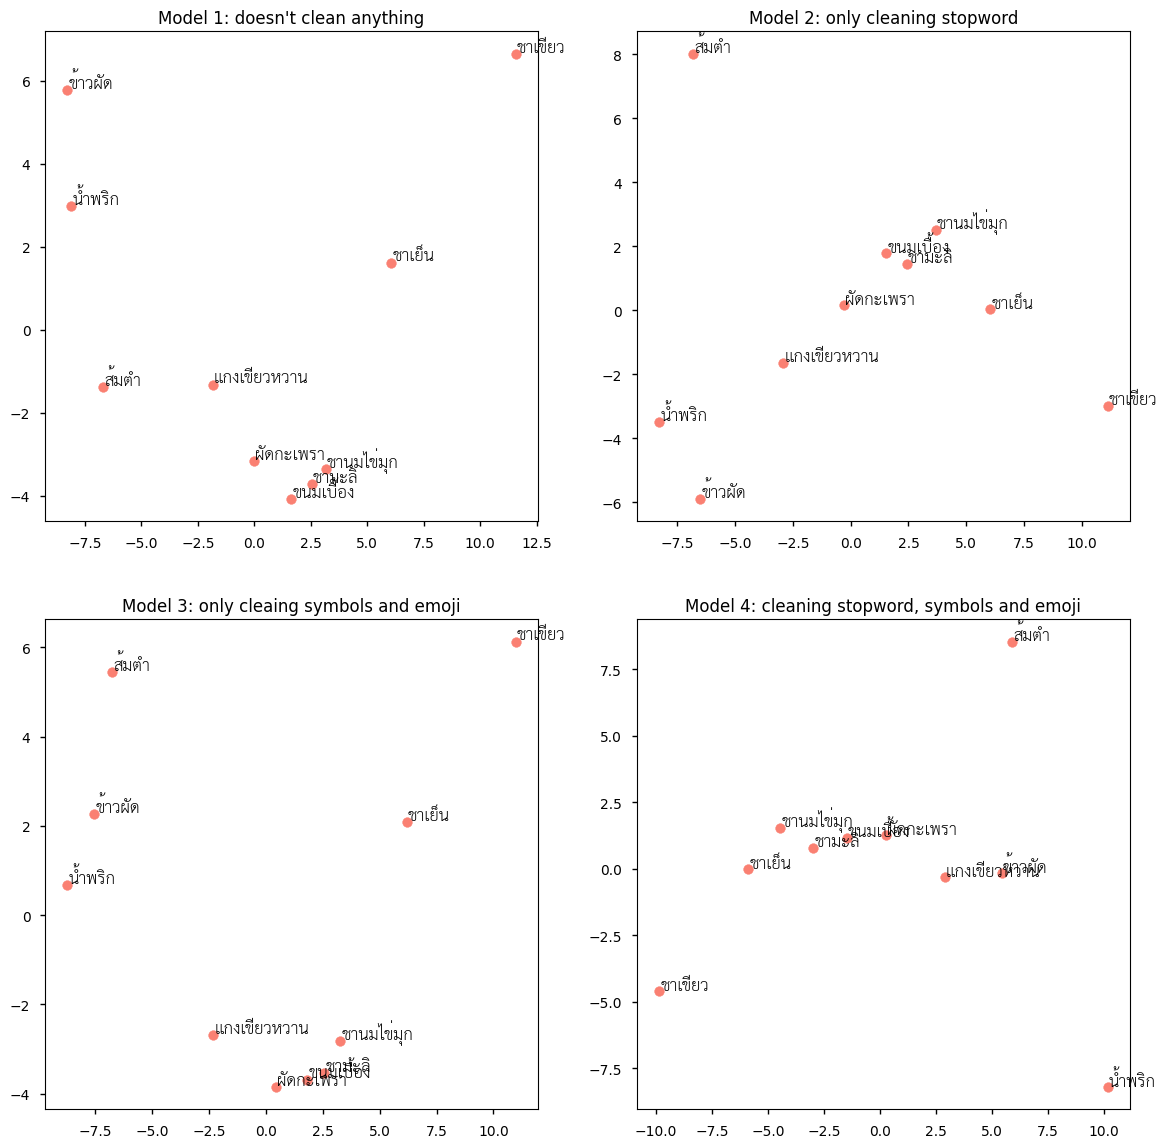

In [23]:
display_plot(words)